##### Copyright 2018 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

이번 파트에서는 CNN을 이용하여 주어진 이미지의 화풍을 레퍼런스 스타일로 합성하는 Neural Style Transfer 실습을 해보겠습니다 [1]. 
원본이미지(content image)와 화풍이미지(style image)가 주어졌을 때, 미리 학습된 CNN의 feature 값을 이용하여 최종 출력 이미지가 원본 이미지와 화풍이미지 모두와 비슷해지도록 최적화합니다. 

[1] <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

예를 들어, 시카고의 전경이 담긴 사진과, 뭉크의 절규가 그려진 사진이 있다고 합시다.
<img src="images/chicago.jpg" width="500px"/>



<img src="images/the_scream.jpg" width="500px"/>

뭉크의 화풍으로 시카고의 전경을 그리면 이렇게 되겠죠?

<img src="stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2 Physical GPUs, 1 Logical GPUs


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

합성을 원하는 원본이미지와 화풍이미지를 선택합니다.

In [4]:
IMAGE_DIR = "./images/"
#style_path = IMAGE_DIR+"landscape.png"
#style_path = IMAGE_DIR+"gogh.jpg"
#style_path = IMAGE_DIR+"style1.png"
#style_path = IMAGE_DIR+"style2.jpg"
#style_path = IMAGE_DIR+"frozen.jpg"
#style_path = IMAGE_DIR+"udnie.jpg"
style_path = IMAGE_DIR+"the_scream.jpg"
#style_path = IMAGE_DIR+"rain_princess.jpg"
#style_path = IMAGE_DIR+"the_shipwreck_of_the_minotaur.jpg"

#content_path = IMAGE_DIR+"cat.jpg"
#content_path = IMAGE_DIR+"seoul.jpg"
content_path = IMAGE_DIR+"chicago.jpg"
#content_path = IMAGE_DIR+"deadpool.jpg"
#content_path = IMAGE_DIR+"willy_wonka_old.jpg"



## Visualize the input

이미지의 크기가 제각각이기 때문에 이미지를 불러와 최대 크기를 제한해줍니다.

In [5]:
def load_img(path_to_img, verbose=False):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    if verbose:
        print("The first pixel after decoding: ", img[0,0,])
    img = tf.image.convert_image_dtype(img, tf.float32)
    if verbose:
        print("The first pixel after converting image: ", img[0,0,])
    shape = tf.cast(tf.shape(img)[:-1], tf.float32) #이미지의 가로세로
    if verbose:
        print("Shape: ", shape)
    long_dim = max(shape) #이미지의 가로 세로중 큰 것
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    if verbose:
        print("New shape: ", new_shape)
    img = tf.image.resize(img, new_shape)
    if verbose:
        print("Resized image shape: ", img.shape)
    img = img[tf.newaxis, :]
    return img

In [6]:
_ = load_img(style_path, verbose=True)

The first pixel after decoding:  tf.Tensor([195 177 127], shape=(3,), dtype=uint8)
The first pixel after converting image:  tf.Tensor([0.76470596 0.69411767 0.49803925], shape=(3,), dtype=float32)
Shape:  tf.Tensor([652. 512.], shape=(2,), dtype=float32)
New shape:  tf.Tensor([512 402], shape=(2,), dtype=int32)
Resized image shape:  (512, 402, 3)


배치 차원을 추가해 주었기 때문에, 배치 차원을 다시 줄이고 이미지를 출력합니다.

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

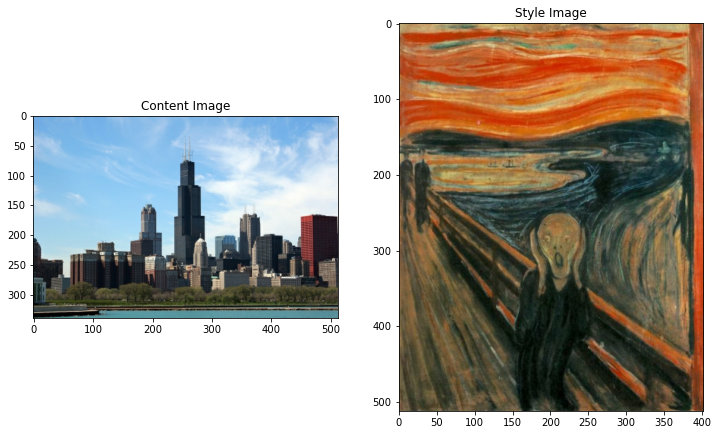

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define content and style representations

<img src="images/style_transfer_model.png">

이번 실습에서는 미리 학습된 VGG 19 네트워크를 사용하도록 하겠습니다. 
Style transfer에는 content loss, style loss 두가지의 로스가 사용됩니다. Content loss는 최종출력 이미지가 content image와 비슷한 feature를 유지하도록 학습합니다. 반대로 style loss는 최종출력 이미지의 스타일이 style image와 비슷해지도록 최종출력 이미지를 optimize합니다.    
이를 위해서, 학습된 네트워크에서 content와 style feature들을 추출할 것입니다. 보통 네트워크의 하위 계층에서는 테두리나 텍스쳐 같은 low-level feature를, 상위 계층에서는 바퀴나 눈과 같은 high-level feature를 학습하는 것으로 알려져있습니다. 따라서, content loss를 계산하기 위해서는 상위 계층의 feature를, style loss를 위해서는 다양한 계층의 feature를 혼합하여 사용하겠습니다.



`VGG19`의 레이어들은 다음과 같습니다

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 23s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


아래, 로스 계산에 쓰일 레이어들을 정의합니다.

In [10]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 
 
`tf.keras.applications`의 모델들은 중간계층을 손쉽게 추출하도록 설계되었습니다. 
아래의 functional API에 원하는 인풋과 아웃풋을 정의할 수 있습니다:

`model = tf.keras.Model(inputs, outputs)`



In [11]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    #vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg = tf.compat.v1.keras.applications.VGG19()
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

예를들어, style_layer들만 추출하고 싶다면 다음과 같이 할 수 있습니다.

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

574717952/574710816 [==============================] - 87s 0us/step


## Calculate content and style


이미지의 content는 위에서 정한 content layer의 feature map으로 간단히 정의합니다.


<img src="images/gram_matrix.png">
Image source: <a href="https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee" class="external">Thushan Ganegedara
</a>



어떤 이미지의 스타일은 각 featuremap들의 correlation으로 정의할 수 있습니다 [2]. 각 레이어에서의 Style matrix 또는 Gram matrix를 구하기 위해서는, 각각의 featuremap들 끼리 inner product를 계산한 후 featurmap의 픽셀 수로 나누어 계산됩니다. 

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

 `tf.linalg.einsum` 함수를 사용하여 gram matrix를 구현해 봅시다. 

In [3]:
def gram_matrix(input_tensor):
    #INPUT
    #input_tensor: featuremap of tf.Tensor with shape (batch_size, height, width, channel)

    #OUTPUT
    #gram_mat: tf.Tensor with shape (batch_size, channel, channel)

    #HINT: tf.linalg.einsum

    # # Matrix multiplication
    # einsum('ij,jk->ik', m0, m1)  # output[i,k] = sum_j m0[i,j] * m1[j, k]

    # # Dot product
    # einsum('i,i->', u, v)  # output = sum_i u[i]*v[i]

    # # Outer product
    # einsum('i,j->ij', u, v)  # output[i,j] = u[i]*v[j]

    # # Transpose
    # einsum('ij->ji', m)  # output[j,i] = m[i,j]

    # # Trace
    # einsum('ii', m)  # output[j,i] = trace(m) = sum_i m[i, i]

    # # Batch matrix multiplication
    # einsum('aij,ajk->aik', s, t)  # out[a,i,k] = sum_j s[a,i,j] * t[a, j, k]
    
    input_shape = tf.shape(input_tensor)

    gram_mat: None
    return gram_mat

## Extract style and content


위에서 정의한 Model을 사용하여 중간계층의 feature 값을 구하는 클래스와 함수를 정의합니다.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.compat.v1.keras.applications.vgg16.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

이미지를 입력으로 넣어주면 `style_layers`의 Gram matrix와 `content_layers`의 content feature 값들을 받아올 수 있습니다.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


## Run gradient descent

추출한 feature 값들을 이용해서, style transfer 알고리즘을 완성할 수 있습니다. 
원본 이미지의 content, style feature 값들과, 합성된 이미지의 content, style feature 값들 간의 MSE(Mean Squared Error)를 계산하여 합성이미지를 업데이트 합니다. 
이 때, content loss와 style loss의 비율을 적절히 맞춰주어야 합니다. 

먼저, 학습의 기준이 될 원본이미지의 style 및 content 값들을 계산합니다. 

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

학습시 이미지가 튀는 것을 방지하기 위해 항상 이미지를 [0,1]로 클립해줍니다.

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

합성 이미지를 학습하기 위해 optimizer를 정의합니다. 원 논문에서는 LBFGS를 추천하지만, `Adam` 도 잘 작동합니다.

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

최종 loss를 정의하기 위해 style loss와 content loss의 비율을 정의합니다.

In [ ]:
style_weight=1e-2
content_weight=1e4

위에서 추출한 style 값을 이용하여 MSE 로스를 계산합니다.

In [ ]:
def style_loss(style_outputs, style_weight):
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    return style_loss

비슷한 방식으로 content loss를 정의해 봅시다.

In [4]:
def content_loss(content_outputs, content_weight):
    content_loss = None
    return content_loss

이제 위에서 정의한 로스를 이용하여 그라디언트를 계산하고, 이미지를 업데이트하는 함수를 정의합니다.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    s_loss = style_loss(outputs['style'], style_weight=style_weight)
    c_loss = content_loss(outputs['content'], content_weight=content_weight)
    loss = s_loss + c_loss
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return s_loss, c_loss

합성이미지를 직접 optimize하기 위해서 `tf.Variable` 로 선언합니다. 학습을 빠르게 하기 위해, 원본이미지로 초기화합니다.

In [ ]:
image = tf.Variable(content_image)

학습을 3번 해봅시다.

In [ ]:
s,c = train_step(image)
print(s,c)
s,c = train_step(image)
print(s,c)
s,c = train_step(image)
print(s,c)
tensor_to_image(image)

작동을 하는 것 같으니, 본격적으로 학습을 해봅시다.

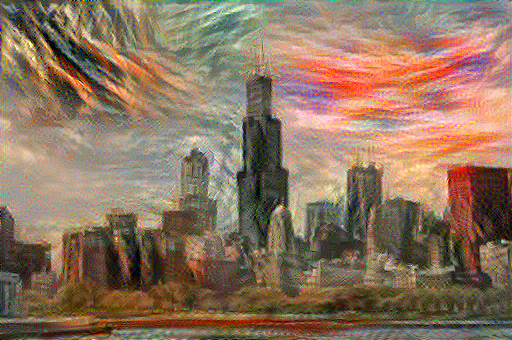

Train step: 1000
Total time: 33.5


In [78]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [79]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

# try:
#   from google.colab import files
# except ImportError:
#    pass
# else:
#   files.download(file_name)